### STEP 1: Setup paths & mount Google Drive

Mounts Google Drive to access the dataset and save results.

Defines dataset and output folder paths.

Ensures the output directory exists for saving enhanced images.

In [1]:
print("Cloning Real-ESRGAN...")
!git clone https://github.com/xinntao/Real-ESRGAN.git
%cd Real-ESRGAN

print("\nInstalling dependencies...")

!pip install basicsr
!pip install facexlib gfpgan
!pip install -r requirements.txt
!python setup.py develop

print("\nDownloading the pre-trained model...")
!wget https://github.com/xinntao/Real-ESRGAN/releases/download/v0.1.0/RealESRGAN_x4plus.pth -P experiments/pretrained_models

print("\nPatching the 'basicsr' library to fix the torchvision error...")
!find / -name degradations.py 2>/dev/null -exec sed -i 's/from torchvision.transforms.functional_tensor import rgb_to_grayscale/from torchvision.transforms.functional import rgb_to_grayscale/g' {} +

print("\n✅ Setup and patching complete. Ready for Step 2.")

Cloning Real-ESRGAN...
Cloning into 'Real-ESRGAN'...
remote: Enumerating objects: 759, done.
remote: Counting objects: 100% (121/121), done.
remote: Compressing objects: 100% (23/23), done.
remote: Total 759 (delta 106), reused 98 (delta 98), pack-reused 638 (from 1)
Receiving objects: 100% (759/759), 5.38 MiB | 28.54 MiB/s, done.
Resolving deltas: 100% (415/415), done.
/content/Real-ESRGAN

Installing dependencies...
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 5.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 3.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 299.4/299.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 57.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 17.0 MB/s eta 0:00:00
  Created wheel for basicsr: filename=basicsr-1.4.2-py3-none-any.whl size=214818 sha256=a00c979135597de381895c2c5d7271a8cc4fa8b5cc8250473

In [2]:

import os
import cv2
import glob
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from basicsr.archs.rrdbnet_arch import RRDBNet
from realesrgan import RealESRGANer
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim


In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### STEP 2: Setup Real-ESRGAN enhancer

Loads the Real-ESRGAN super-resolution model (RRDBNet).

Checks if GPU (cuda) is available for faster processing.

Prepares the model for 4× image enhancement.

In [4]:
device = 'cuda' if cv2.cuda.getCudaEnabledDeviceCount() > 0 else 'cpu'
print("Using device:", device)

model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
enhancer = RealESRGANer(
    scale=4,
    model_path='experiments/pretrained_models/RealESRGAN_x4plus.pth',
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=True,
    device=device
)
print("✅ Real-ESRGAN enhancer ready!")


Using device: cpu
✅ Real-ESRGAN enhancer ready!


### STEP 3: Helper functions and Group slices by patient

Defines functions to measure sharpness of an image using the Laplacian method.

Used to select the sharpest slice (best quality image) for each patient.

Scans all .png images in the dataset folder.

Groups them based on patient IDs (folder names).

Selects the sharpest slice per patient for enhancement.

In [5]:
dataset_path = "/content/drive/MyDrive/heart_mri_ct/mri_dataset"
output_path = "/content/drive/MyDrive/module2_single_slice_results"
os.makedirs(output_path, exist_ok=True)
print(f"✅ Output folder ready: {output_path}")

def calculate_sharpness(image_path):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    return cv2.Laplacian(img, cv2.CV_64F).var()

def select_sharpest_slice(slice_paths):
    max_sharpness = -1
    sharpest_slice = None
    for path in slice_paths:
        s = calculate_sharpness(path)
        if s > max_sharpness:
            max_sharpness = s
            sharpest_slice = path
    return sharpest_slice

patient_slices = {}
all_files = glob.glob(os.path.join(dataset_path, "**", "*.png"), recursive=True)

for f_path in all_files:
    patient_id = os.path.basename(os.path.dirname(f_path))
    if patient_id not in patient_slices:
        patient_slices[patient_id] = []
    patient_slices[patient_id].append(f_path)

for pid in patient_slices:
    patient_slices[pid].sort()

recommended_slices = []
for pid, slices in patient_slices.items():
    if slices:
        recommended_slices.append(select_sharpest_slice(slices))
print(f"✅ Selected {len(recommended_slices)} recommended slices (1 per patient).")


device = 'cuda' if cv2.cuda.getCudaEnabledDeviceCount() > 0 else 'cpu'
print("Using device:", device)

model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
enhancer = RealESRGANer(
    scale=4,
    model_path='experiments/pretrained_models/RealESRGAN_x4plus.pth',
    model=model,
    tile=0,
    tile_pad=10,
    pre_pad=0,
    half=True,
    device=device
)
print("✅ Real-ESRGAN enhancer ready!")

✅ Output folder ready: /content/drive/MyDrive/module2_single_slice_results
✅ Selected 150 recommended slices (1 per patient).
Using device: cpu
✅ Real-ESRGAN enhancer ready!


### STEP 4: Enhance slices & compute metrics (resumable)

Enhances selected slices using the ESRGAN model.

Computes PSNR and SSIM to measure image quality before and after enhancement.

Saves enhanced images, bicubic (before) images, and ground truth to Google Drive.

Includes resume logic — if stopped, it continues from where it left off.

In [8]:

comparison_images = []
all_metrics = []

processed_files = [f for f in os.listdir(output_path) if f.endswith("_after_GenAI.png")]
processed_indices = [int(f.split("_")[0]) for f in processed_files]
start_index = max(processed_indices, default=-1) + 1
print(f"Resuming from slice #{start_index} of {len(recommended_slices)}")

for i, img_path in enumerate(recommended_slices[start_index:], start=start_index):
    img_name = os.path.basename(img_path)
    print(f"\nProcessing {img_name} ...")

    gt_hr_gray = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = gt_hr_gray.shape
    h_crop, w_crop = h - (h % 4), w - (w % 4)
    gt_hr_gray = gt_hr_gray[0:h_crop, 0:w_crop]

    input_lr_gray = cv2.resize(gt_hr_gray, (w_crop//4, h_crop//4), interpolation=cv2.INTER_CUBIC)
    before_bicubic_hr = cv2.resize(input_lr_gray, (w_crop, h_crop), interpolation=cv2.INTER_CUBIC)
    input_lr_rgb = cv2.cvtColor(input_lr_gray, cv2.COLOR_GRAY2RGB)

    try:
        enhanced_rgb, _ = enhancer.enhance(input_lr_rgb, outscale=4)
    except:

        enhancer_fp32 = RealESRGANer(
            scale=4,
            model_path='experiments/pretrained_models/RealESRGAN_x4plus.pth',
            model=model,
            tile=0, tile_pad=10, pre_pad=0, half=False, device=device)
        enhanced_rgb, _ = enhancer_fp32.enhance(input_lr_rgb, outscale=4)

    after_genai_hr = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2GRAY)

    psnr_before = psnr(gt_hr_gray, before_bicubic_hr, data_range=255)
    ssim_before = ssim(gt_hr_gray, before_bicubic_hr, data_range=255)
    psnr_after = psnr(gt_hr_gray, after_genai_hr, data_range=255)
    ssim_after = ssim(gt_hr_gray, after_genai_hr, data_range=255)

    metrics = {
        "name": img_name,
        "psnr_before": psnr_before,
        "ssim_before": ssim_before,
        "psnr_after": psnr_after,
        "ssim_after": ssim_after
    }
    all_metrics.append(metrics)

    comparison_images.append({
        "name": img_name,
        "before": before_bicubic_hr,
        "after": after_genai_hr,
        "truth": gt_hr_gray
    })

    cv2.imwrite(os.path.join(output_path, f"{i}_before_bicubic.png"), before_bicubic_hr)
    cv2.imwrite(os.path.join(output_path, f"{i}_after_GenAI.png"), after_genai_hr)
    cv2.imwrite(os.path.join(output_path, f"{i}_ground_truth.png"), gt_hr_gray)

    print(f"PSNR BEFORE: {psnr_before:.2f}, SSIM BEFORE: {ssim_before:.4f}")
    print(f"PSNR AFTER:  {psnr_after:.2f}, SSIM AFTER:  {ssim_after:.4f}")

print("\n✅ All enhancement completed. Results saved to Drive.")

Resuming from slice #109 of 150

Processing slice_030.png ...
PSNR BEFORE: 25.34, SSIM BEFORE: 0.9351
PSNR AFTER:  27.49, SSIM AFTER:  0.9267

Processing slice_105.png ...
PSNR BEFORE: 25.48, SSIM BEFORE: 0.9355
PSNR AFTER:  27.67, SSIM AFTER:  0.9262

Processing slice_068.png ...
PSNR BEFORE: 25.68, SSIM BEFORE: 0.9373
PSNR AFTER:  27.74, SSIM AFTER:  0.9258

Processing slice_099.png ...
PSNR BEFORE: 25.94, SSIM BEFORE: 0.9421
PSNR AFTER:  27.88, SSIM AFTER:  0.9285

Processing slice_007.png ...
PSNR BEFORE: 26.68, SSIM BEFORE: 0.9439
PSNR AFTER:  28.65, SSIM AFTER:  0.9261

Processing slice_040.png ...
PSNR BEFORE: 26.31, SSIM BEFORE: 0.9471
PSNR AFTER:  28.35, SSIM AFTER:  0.9354

Processing slice_050.png ...
PSNR BEFORE: 25.86, SSIM BEFORE: 0.9408
PSNR AFTER:  28.58, SSIM AFTER:  0.9321

Processing slice_005.png ...
PSNR BEFORE: 25.44, SSIM BEFORE: 0.9354
PSNR AFTER:  27.62, SSIM AFTER:  0.9263

Processing slice_108.png ...
PSNR BEFORE: 26.13, SSIM BEFORE: 0.9445
PSNR AFTER:  28.58

### STEP 5: Visualize results

Selects one patient and displays 3 slices.

Shows side-by-side comparison of “Before Enhancement” (bicubic) and “After Enhancement” (GenAI).

📸 Displaying 3 slices of patient: Patient_147


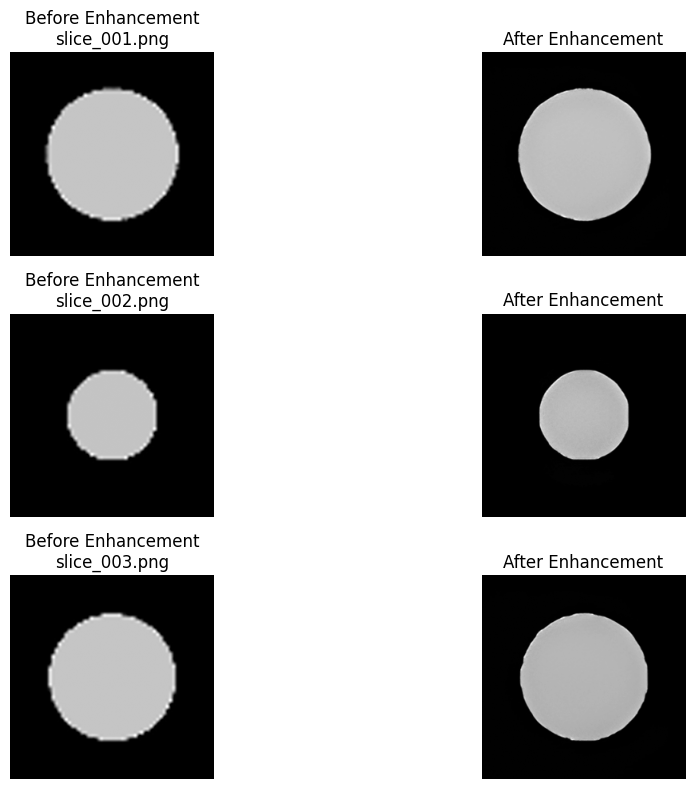

In [9]:

import matplotlib.pyplot as plt

sample_patient_id = list(patient_slices.keys())[0]
sample_slices = sorted(patient_slices[sample_patient_id])[:3]

print(f"📸 Displaying 3 slices of patient: {sample_patient_id}")

plt.figure(figsize=(12, 8))

for idx, img_path in enumerate(sample_slices):
    img_name = os.path.basename(img_path)

    gt = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    h, w = gt.shape
    h_crop, w_crop = h - (h % 4), w - (w % 4)
    gt = gt[0:h_crop, 0:w_crop]

    lr = cv2.resize(gt, (w_crop//4, h_crop//4), interpolation=cv2.INTER_CUBIC)
    before_bicubic = cv2.resize(lr, (w_crop, h_crop), interpolation=cv2.INTER_CUBIC)

    input_lr_rgb = cv2.cvtColor(lr, cv2.COLOR_GRAY2RGB)
    enhanced_rgb, _ = enhancer.enhance(input_lr_rgb, outscale=4)
    after_genai = cv2.cvtColor(enhanced_rgb, cv2.COLOR_RGB2GRAY)

    plt.subplot(3, 2, 2*idx + 1)
    plt.imshow(before_bicubic, cmap='gray')
    plt.title(f"Before Enhancement\n{img_name}")
    plt.axis('off')

    plt.subplot(3, 2, 2*idx + 2)
    plt.imshow(after_genai, cmap='gray')
    plt.title("After Enhancement")
    plt.axis('off')

plt.tight_layout()
plt.show()
